In [79]:
import joblib
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PowerTransformer
STATE=26

In [80]:
df = pd.read_csv("bank-marketing.csv")
data = df.copy()
data.columns = ["Age", "Job", "MaritalStatus", "EducationLevel", "CreditDefault", "ActBalance",
              "HousingLoan", "PersonalLoan", "ContactType", "Day", "Month", "ContactDuration", 
              "NumOfCampaign", "PassedDays", "NumOfPreviousContacts", "OutcomeOfPreviousCampaign", "Class"]
data = data.drop("Day", axis=1)

In [81]:
data.head(3)

,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts,OutcomeOfPreviousCampaign,Class
0,30,unemployed,married,primary,no,1787,no,no,cellular,oct,79,1,-1,0,unknown,1
1,33,services,married,secondary,no,4789,yes,yes,cellular,may,220,1,339,4,failure,1
2,35,management,single,tertiary,no,1350,yes,no,cellular,apr,185,1,330,1,failure,1


pd.set_option('display.max_rows', None)

In [82]:
data_X = data.drop("Class", axis=1)
data_y = data["Class"]

## Deal with missing values before sampling

In [83]:
missing_features = ["OutcomeOfPreviousCampaign"]
mode_features = ["Age", "Job", "MaritalStatus", "EducationLevel", "CreditDefault", "ActBalance",
              "HousingLoan", "PersonalLoan", "ContactType", "Month", "ContactDuration", 
              "NumOfCampaign", "PassedDays", "NumOfPreviousContacts"]

imputer_missing = Pipeline(steps=[('imputer', SimpleImputer(missing_values='unknown', 
                                                            strategy='constant', fill_value='Missing'))
                                 ])
imputer_mode = Pipeline(steps=[('imputer', SimpleImputer(missing_values='unknown', 
                                                        strategy='most_frequent'))
                              ])

preprocessor = ColumnTransformer(transformers=[('imputer_missing', imputer_missing, missing_features),
                                              ('imputer_mode', imputer_mode, mode_features)])

data_not_na =preprocessor.fit_transform(data_X)

In [84]:
col_names = ["OutcomeOfPreviousCampaign", "Age", "Job", "MaritalStatus", "EducationLevel", "CreditDefault", 
             "ActBalance","HousingLoan", "PersonalLoan", "ContactType", "Month", "ContactDuration", 
             "NumOfCampaign", "PassedDays", "NumOfPreviousContacts"]

#numeric_vars = ['Age', 'EducationLevel', 'ActBalance', 'ContactDuration', 'NumOfCampaign', 
#                'PassedDays', 'NumOfPreviousContacts']

print(len(col_names))


15


### Mappings

In [85]:

job_dict = {'unemployed': 'unemployed', 'services': 'employed',  'management': 'employed', 'blue-collar':'employed',
            'self-employed': 'employed', 'technician': 'employed', 'entrepreneur': 'employed',
            'admin.':'employed',  'student':'student', 'housemaid':'employed', 'retired':'retired'}

month_dict = {'jan':0, 'feb':1, 'mar':2, 'apr':3, 'may':4, 'jun':5, 'jul':6,
             'aug':7, 'sep':8, 'oct':9, 'nov':10, 'dec':11}

educ_dict = {'primary':1, 'secondary':2, 'tertiary':3}

In [86]:
dfx = pd.DataFrame(data_not_na, columns=col_names)

# Mapping EducationLevel
dfx["EducationLevel"] = dfx["EducationLevel"].map(educ_dict).astype('int64')
dfx["Job"] = dfx["Job"].map(job_dict)
dfx["Month"] = dfx["Month"].map(month_dict).astype('int64')



In [87]:
# check for nan values
nan_variables = [x for x in dfx.columns if dfx[x].isnull().sum() > 0]
nan_variables

[]

In [88]:
dfx.dtypes

OutcomeOfPreviousCampaign    object
Age                          object
Job                          object
MaritalStatus                object
EducationLevel                int64
CreditDefault                object
ActBalance                   object
HousingLoan                  object
PersonalLoan                 object
ContactType                  object
Month                         int64
ContactDuration              object
NumOfCampaign                object
PassedDays                   object
NumOfPreviousContacts        object
dtype: object

In [41]:
dfx.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts
0,Missing,30,unemployed,married,1,no,1787,no,no,cellular,9,79,1,-1,0
1,failure,33,employed,married,2,no,4789,yes,yes,cellular,4,220,1,339,4
2,failure,35,employed,single,3,no,1350,yes,no,cellular,3,185,1,330,1


## Oversample

### To do: find correlation heatmap for both sampled and unsampled data

In [89]:
numeric_vars = ['Age', 'EducationLevel', 'ActBalance', 'Month', 'ContactDuration', 'NumOfCampaign', 
                'PassedDays', 'NumOfPreviousContacts']


In [90]:
dfx[numeric_vars] = dfx[numeric_vars].astype(int)

In [91]:
dfx[numeric_vars].corr()

,Age,EducationLevel,ActBalance,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts
Age,1.000000,-0.188881,0.083820,0.073764,-0.002367,-0.005148,-0.008894,-0.003511
EducationLevel,-0.188881,1.000000,0.054449,0.082168,-0.010469,0.010531,0.011039,0.030080
ActBalance,0.083820,0.054449,1.000000,0.099872,-0.015950,-0.009976,0.009437,0.026196
Month,0.073764,0.082168,0.099872,1.000000,-0.000282,0.059214,-0.112003,-0.037410
ContactDuration,-0.002367,-0.010469,-0.015950,-0.000282,1.000000,-0.068382,0.010380,0.018080
NumOfCampaign,-0.005148,0.010531,-0.009976,0.059214,-0.068382,1.000000,-0.093137,-0.067833
PassedDays,-0.008894,0.011039,0.009437,-0.112003,0.010380,-0.093137,1.000000,0.577562
NumOfPreviousContacts,-0.003511,0.030080,0.026196,-0.037410,0.018080,-0.067833,0.577562,1.000000


In [44]:
dfx.dtypes

OutcomeOfPreviousCampaign    object
Age                           int64
Job                          object
MaritalStatus                object
EducationLevel                int64
CreditDefault                object
ActBalance                    int64
HousingLoan                  object
PersonalLoan                 object
ContactType                  object
Month                         int64
ContactDuration               int64
NumOfCampaign                 int64
PassedDays                    int64
NumOfPreviousContacts         int64
dtype: object

In [92]:
cat_features = [dfx[var].dtype == 'O' for var in dfx.columns]
dfx.columns[cat_features]

Index(['OutcomeOfPreviousCampaign', 'Job', 'MaritalStatus', 'CreditDefault',
       'HousingLoan', 'PersonalLoan', 'ContactType'],
      dtype='object')

In [113]:
smote_nc = SMOTENC(categorical_features=cat_features, random_state=STATE)
X_resampled, y_resampled = smote_nc.fit_resample(dfx, data_y)

In [94]:
X_resampled.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts
0,Missing,30,unemployed,married,1,no,1787,no,no,cellular,9,79,1,-1,0
1,failure,33,employed,married,2,no,4789,yes,yes,cellular,4,220,1,339,4
2,failure,35,employed,single,3,no,1350,yes,no,cellular,3,185,1,330,1


In [14]:
y_resampled

0       1
1       1
2       1
3       1
4       1
       ..
7995    2
7996    2
7997    2
7998    2
7999    2
Name: Class, Length: 8000, dtype: int64

In [95]:
X_resampled[numeric_vars].corr()

,Age,EducationLevel,ActBalance,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts
Age,1.000000,-0.218731,0.135106,0.011009,-0.004160,-0.031287,0.028221,0.008506
EducationLevel,-0.218731,1.000000,0.031661,0.065257,-0.124768,0.036922,0.002424,0.039682
ActBalance,0.135106,0.031661,1.000000,0.061371,-0.056208,-0.015839,0.019939,0.045024
Month,0.011009,0.065257,0.061371,1.000000,-0.020785,0.058321,-0.056656,-0.013323
ContactDuration,-0.004160,-0.124768,-0.056208,-0.020785,1.000000,-0.010862,-0.035656,-0.034026
NumOfCampaign,-0.031287,0.036922,-0.015839,0.058321,-0.010862,1.000000,-0.097835,-0.081772
PassedDays,0.028221,0.002424,0.019939,-0.056656,-0.035656,-0.097835,1.000000,0.578855
NumOfPreviousContacts,0.008506,0.039682,0.045024,-0.013323,-0.034026,-0.081772,0.578855,1.000000


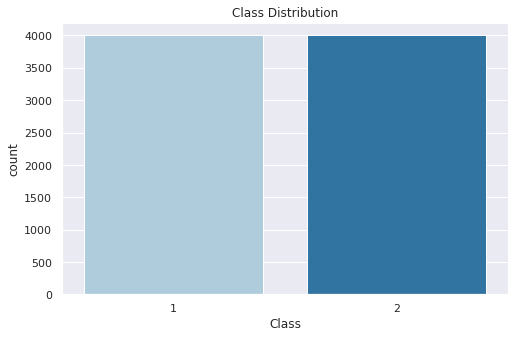

In [114]:
counts = sns.countplot(x=y_resampled, data=X_resampled, palette="Paired")
plt.title("Class Distribution")
plt.savefig("SClass_Distribution.png")

## Train/Test Split

In [96]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.1, 
                                                stratify=y_resampled, random_state=STATE)
#plot distribution to show stratified
print(Xtrain.shape)
Xtest.shape

(7200, 15)


(800, 15)

In [97]:
Xtrain.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts
4716,Missing,30,employed,married,2,no,-243,yes,no,cellular,5,571,2,274,2
706,Missing,33,employed,single,3,no,123,no,no,cellular,7,264,1,-1,0
6756,Missing,27,employed,single,2,no,170,no,no,cellular,2,95,1,-1,0


### Feature Engineer for tree-based algorithms end

In [21]:
cat_columns = Xtrain.columns[cat_features]

In [26]:
# normalize 
scaler = StandardScaler()
Xtrain[numeric_vars] = scaler.fit_transform(Xtrain[numeric_vars])
Xtest[numeric_vars] = scaler.transform(Xtest[numeric_vars])

In [27]:
Xtrain.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts
4716,0,-0.049211,0,1,1,0,-0.648337,1,0,0,8,0.339014,-0.543458,0.083001,-0.4043
706,0,-0.793576,0,2,2,0,-0.499376,0,0,0,1,-0.360387,-0.543458,-0.488050,-0.4043
6756,0,-1.165758,0,2,2,0,-0.482581,0,0,0,5,-0.854592,-0.543458,-0.488050,-0.4043


In [22]:
# Lagel Encode categorical variables
for cat in cat_columns:
    le = LabelEncoder()
    Xtrain[cat] = le.fit_transform(Xtrain[cat])
    Xtest[cat] = le.transform(Xtest[cat])

In [23]:
Xtrain.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts
4716,0,41,0,1,1,0,-285,1,0,0,8,506,1,57,0
706,0,33,0,2,2,0,123,0,0,0,1,264,1,-1,0
6756,0,29,0,2,2,0,169,0,0,0,5,93,1,-1,0


In [24]:
Xtrain.dtypes

OutcomeOfPreviousCampaign    int64
Age                          int64
Job                          int64
MaritalStatus                int64
EducationLevel               int64
CreditDefault                int64
ActBalance                   int64
HousingLoan                  int64
PersonalLoan                 int64
ContactType                  int64
Month                        int64
ContactDuration              int64
NumOfCampaign                int64
PassedDays                   int64
NumOfPreviousContacts        int64
dtype: object

Xtrain.to_csv('Xtrain_treeBased_normalized.csv', index=False)
Xtest.to_csv('Xtest_treeBased_normalized.csv', index=False)

ytrain.to_csv('ytrain_treeBased_normalized.csv', index=False)
ytest.to_csv('ytest_treeBased_normalized.csv', index=False)

## Non-tree based algorithms transformations

# Transformations

## Numeric Variables

    * yeo-johnson skewed variable
    * feature scaling - StandardScaler for other numeric values
    

### Cyclic encode month variable using sin and cos

In [98]:
X_resampled["Month_sin"] = np.sin(2 * np.pi * X_resampled["Month"]/11)
X_resampled["Month_cos"] = np.cos(2 * np.pi * X_resampled["Month"]/11)

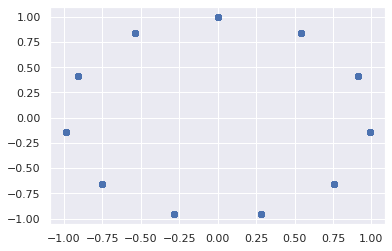

In [99]:
sns.set(style="darkgrid")
plt.scatter(X_resampled["Month_sin"], X_resampled["Month_cos"])

In [51]:
X_resampled.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,Month,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts,Month_sin,Month_cos
0,Missing,30,unemployed,married,1,no,1787,no,no,cellular,9,79,1,-1,0,-0.909632,0.415415
1,failure,33,employed,married,2,no,4789,yes,yes,cellular,4,220,1,339,4,0.755750,-0.654861
2,failure,35,employed,single,3,no,1350,yes,no,cellular,3,185,1,330,1,0.989821,-0.142315


In [100]:
# drop month variable

X_resampled = X_resampled.drop("Month", axis=1)
X_resampled.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts,Month_sin,Month_cos
0,Missing,30,unemployed,married,1,no,1787,no,no,cellular,79,1,-1,0,-0.909632,0.415415
1,failure,33,employed,married,2,no,4789,yes,yes,cellular,220,1,339,4,0.755750,-0.654861
2,failure,35,employed,single,3,no,1350,yes,no,cellular,185,1,330,1,0.989821,-0.142315


In [53]:
X_resampled.dtypes

OutcomeOfPreviousCampaign     object
Age                            int64
Job                           object
MaritalStatus                 object
EducationLevel                 int64
CreditDefault                 object
ActBalance                     int64
HousingLoan                   object
PersonalLoan                  object
ContactType                   object
ContactDuration                int64
NumOfCampaign                  int64
PassedDays                     int64
NumOfPreviousContacts          int64
Month_sin                    float64
Month_cos                    float64
dtype: object

In [101]:
cyclic_vars = ["Month_sin", "Month_cos"]

In [102]:
numeric_vars = ['Age', 'EducationLevel', 'ActBalance', 'ContactDuration', 'Month_sin', 'Month_cos',
                'NumOfCampaign', 'PassedDays', 'NumOfPreviousContacts']
categoric_vars = [var for var in X_resampled.columns if var not in numeric_vars]

print(len(numeric_vars))
len(categoric_vars)

9


7

### Split into train-test for the remaining transformations

In [103]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.1, 
                                                stratify=y_resampled, random_state=STATE)
#plot distribution to show stratified
print(Xtrain.shape)
Xtest.shape

(7200, 16)


(800, 16)

In [57]:
Xtrain.head()

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts,Month_sin,Month_cos
4716,Missing,30,employed,married,2,no,-243,yes,no,cellular,571,2,274,2,0.281733,-0.959493
706,Missing,33,employed,single,3,no,123,no,no,cellular,264,1,-1,0,-0.755750,-0.654861
6756,Missing,27,employed,single,2,no,170,no,no,cellular,95,1,-1,0,0.909632,0.415415
916,Missing,36,employed,married,2,no,13,no,no,cellular,284,1,-1,0,0.281733,-0.959493
3534,failure,47,employed,single,2,no,1544,yes,no,cellular,104,1,312,1,0.989821,-0.142315


### Yeo-Johnson skewed variables

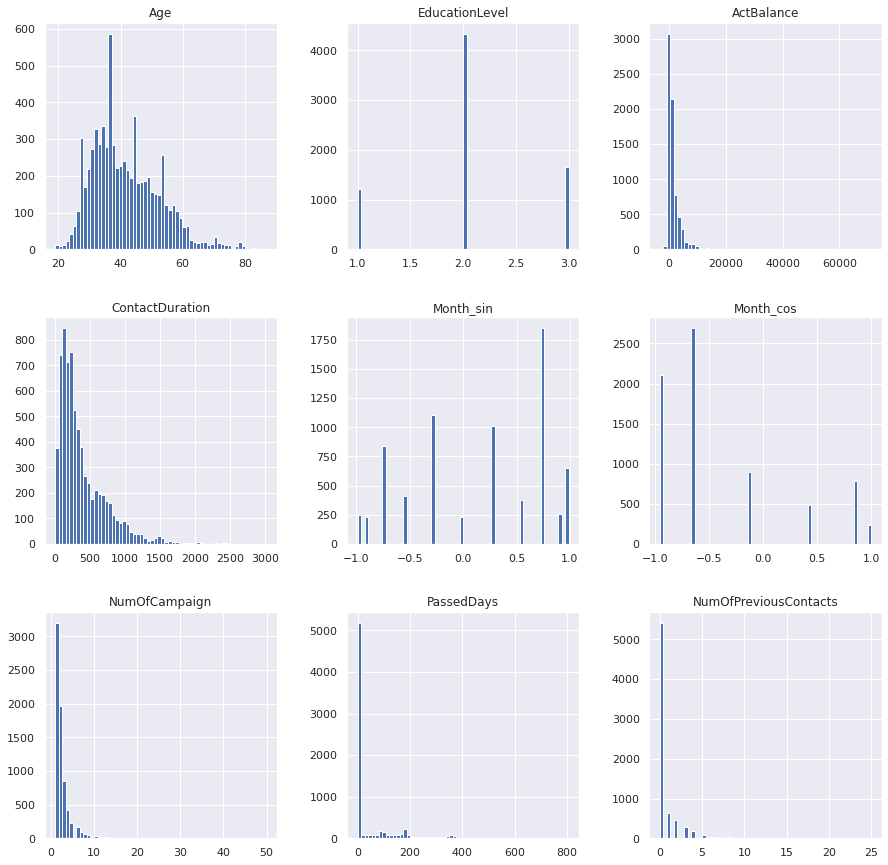

In [104]:
# Finding skewed variables

Xtrain[numeric_vars].hist(bins=60, figsize=(15,15))
plt.show()

### "ContactDuration" and "PassedDays" are skewed, let's visualize more

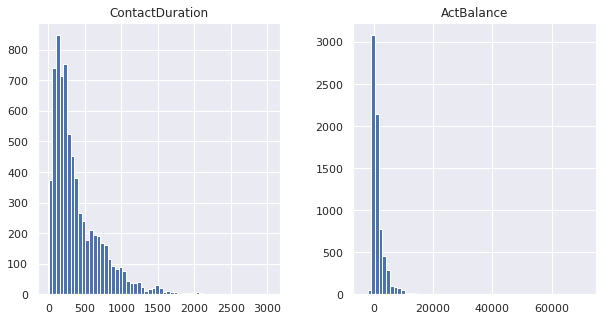

In [105]:
skew_vars = ["ContactDuration", "ActBalance"]
Xtrain[skew_vars].hist(bins=60, figsize=(10,5))
plt.show()

In [106]:
# power-transformer
skewed_variables = ["ContactDuration", "ActBalance"]

ptf = PowerTransformer()
Xtrain[skewed_variables] = ptf.fit_transform(Xtrain[skewed_variables])
Xtest[skewed_variables] = ptf.transform(Xtest[skewed_variables])

array([[<AxesSubplot:title={'center':'ContactDuration'}>,
        <AxesSubplot:title={'center':'ActBalance'}>]], dtype=object)

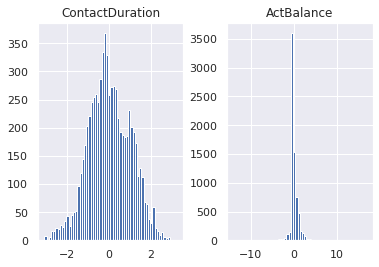

In [107]:
Xtrain[skewed_variables].hist(bins=60)

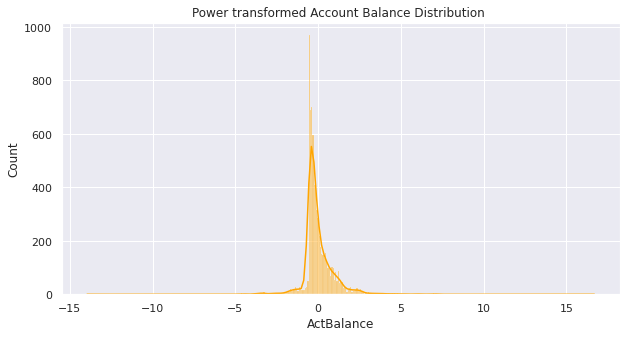

In [117]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.histplot(data=Xtrain, x = "ActBalance", kde=True, color='orange')
plt.title("Power transformed Account Balance Distribution ")
plt.savefig("yeoActBalance.png")

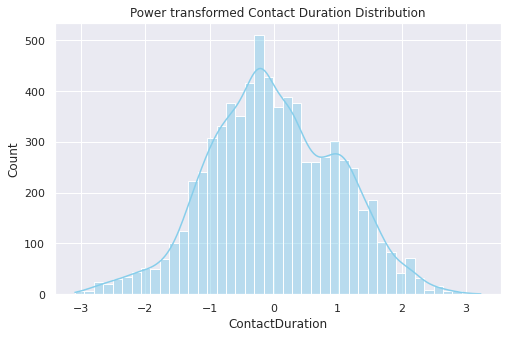

In [118]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.histplot(data=Xtrain, x = "ContactDuration", kde=True, color='skyblue')
plt.title("Power transformed Contact Duration Distribution")
plt.savefig("yeoContact.png")

### Standard the rest of the numeric variables

In [63]:
# Standard scaling
sc_variables = [var for var in numeric_vars if var not in (skewed_variables+cyclic_vars)]

scaler = StandardScaler()
Xtrain[sc_variables] = scaler.fit_transform(Xtrain[sc_variables])
Xtest[sc_variables] = scaler.transform(Xtest[sc_variables])

In [64]:
Xtrain[numeric_vars].var().astype('int64')

Age                      1
EducationLevel           1
ActBalance               1
ContactDuration          1
Month_sin                0
Month_cos                0
NumOfCampaign            1
PassedDays               1
NumOfPreviousContacts    1
dtype: int64

In [71]:
len(numeric_vars)

9

In [65]:
Xtrain.head(3)

,OutcomeOfPreviousCampaign,Age,Job,MaritalStatus,EducationLevel,CreditDefault,ActBalance,HousingLoan,PersonalLoan,ContactType,ContactDuration,NumOfCampaign,PassedDays,NumOfPreviousContacts,Month_sin,Month_cos
4716,Missing,-1.071195,employed,married,-0.097284,no,-1.176285,yes,no,cellular,0.804685,-0.164974,2.213308,0.817008,0.281733,-0.959493
706,Missing,-0.794596,employed,single,1.494639,no,-0.448443,no,no,cellular,-0.085233,-0.543380,-0.489929,-0.406210,-0.755750,-0.654861
6756,Missing,-1.347794,employed,single,-0.097284,no,-0.422331,no,no,cellular,-1.079707,-0.543380,-0.489929,-0.406210,0.909632,0.415415


In [ ]:
### Use this grapth for visualization

## Categorical Variables

###  - one-hot encode categorical variables

In [ ]:
# try sklearn_pandas here

In [70]:
categorical_vars = [var for var in Xtrain.columns if var not in numeric_vars]
len(categorical_vars)

7

In [67]:
# one_hot_encode
ohe = OneHotEncoder(sparse=False, drop='if_binary')

tmp_train = ohe.fit_transform(Xtrain[categorical_vars])
tmp_test = ohe.transform(Xtest[categorical_vars])
Xtrain_cat = pd.DataFrame(tmp_train, columns=ohe.get_feature_names())
Xtest_cat = pd.DataFrame(tmp_test, columns=ohe.get_feature_names())

/home/d_duodua/anaconda3/envs/denv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/d_duodua/anaconda3/envs/denv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [68]:
Xtrain_cat.head(2)

,x0_Missing,x0_failure,x0_other,x0_success,x1_employed,x1_retired,x1_student,x1_unemployed,x2_divorced,x2_married,x2_single,x3_yes,x4_yes,x5_yes,x6_telephone
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [69]:
Xtest_cat.head(2)

,x0_Missing,x0_failure,x0_other,x0_success,x1_employed,x1_retired,x1_student,x1_unemployed,x2_divorced,x2_married,x2_single,x3_yes,x4_yes,x5_yes,x6_telephone
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [72]:
Xtrain_num = Xtrain[numeric_vars].reset_index(drop=True)
Xtest_num = Xtest[numeric_vars].reset_index(drop=True)

In [73]:
Xtrain_num.head(2)

,Age,EducationLevel,ActBalance,ContactDuration,Month_sin,Month_cos,NumOfCampaign,PassedDays,NumOfPreviousContacts
0,-1.071195,-0.097284,-1.176285,0.804685,0.281733,-0.959493,-0.164974,2.213308,0.817008
1,-0.794596,1.494639,-0.448443,-0.085233,-0.755750,-0.654861,-0.543380,-0.489929,-0.406210


In [74]:
cat_features = list(ohe.get_feature_names())
features = cat_features + numeric_vars
len(features)

/home/d_duodua/anaconda3/envs/denv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


24

In [75]:
X_train = pd.DataFrame(pd.concat([Xtrain_cat, Xtrain_num], axis=1, ignore_index=True).values, columns=features)
X_test = pd.DataFrame(pd.concat([Xtest_cat, Xtest_num], axis=1, ignore_index=True).values, columns=features)

In [76]:
X_train.head()

,x0_Missing,x0_failure,x0_other,x0_success,x1_employed,x1_retired,x1_student,x1_unemployed,x2_divorced,x2_married,...,x6_telephone,Age,EducationLevel,ActBalance,ContactDuration,Month_sin,Month_cos,NumOfCampaign,PassedDays,NumOfPreviousContacts
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-1.071195,-0.097284,-1.176285,0.804685,0.281733,-0.959493,-0.164974,2.213308,0.817008
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.794596,1.494639,-0.448443,-0.085233,-0.755750,-0.654861,-0.543380,-0.489929,-0.406210
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.347794,-0.097284,-0.422331,-1.079707,0.909632,0.415415,-0.543380,-0.489929,-0.406210
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.517996,-0.097284,-0.519436,-0.006454,0.281733,-0.959493,-0.543380,-0.489929,-0.406210
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.496201,-0.097284,0.165444,-0.999341,0.989821,-0.142315,-0.543380,2.586846,0.205399


In [77]:
X_train.describe()

,x0_Missing,x0_failure,x0_other,x0_success,x1_employed,x1_retired,x1_student,x1_unemployed,x2_divorced,x2_married,...,x6_telephone,Age,EducationLevel,ActBalance,ContactDuration,Month_sin,Month_cos,NumOfCampaign,PassedDays,NumOfPreviousContacts
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,...,7200.000000,7.200000e+03,7.200000e+03,7.200000e+03,7.200000e+03,7200.000000,7200.000000,7.200000e+03,7.200000e+03,7.200000e+03
mean,0.804861,0.086944,0.032917,0.075278,0.932639,0.038472,0.011806,0.017083,0.101528,0.627361,...,0.041944,2.011662e-16,-9.097661e-17,-1.480105e-17,7.337341e-16,0.158979,-0.391494,1.031274e-16,7.458540e-17,-1.989150e-16
std,0.396335,0.281773,0.178431,0.263857,0.250664,0.192347,0.108018,0.129591,0.302047,0.483541,...,0.200476,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,0.649006,0.632742,1.000069e+00,1.000069e+00,1.000069e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-2.085392e+00,-1.689208e+00,-1.395970e+01,-3.098449e+00,-0.989821,-0.959493,-5.433803e-01,-4.899289e-01,-4.062104e-01
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-7.945955e-01,-9.728420e-02,-4.601733e-01,-6.869085e-01,-0.281733,-0.959493,-5.433803e-01,-4.899289e-01,-4.062104e-01
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,-1.491971e-01,-9.728420e-02,-2.335908e-01,-6.509650e-02,0.281733,-0.654861,-1.649745e-01,-4.899289e-01,-4.062104e-01
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,6.806007e-01,-9.728420e-02,2.745907e-01,7.364155e-01,0.755750,-0.142315,2.134314e-01,-1.809121e-02,-4.062104e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,4.184192e+00,1.494639e+00,1.668704e+01,3.232095e+00,0.989821,1.000000,1.799851e+01,7.462502e+00,1.488402e+01


In [78]:
X_train.to_csv('Xtrain_regression.csv', index=False)
X_test.to_csv('Xtest_regression.csv', index=False)

ytrain.to_csv('ytrain_regression.csv', index=False)
ytest.to_csv('ytest_regression.csv', index=False)